## Requirement is to group customers in clusters of size 3 on average, so that any service executive can pick two or more nearby clusters as per his wish for servicing

In [1]:
import datetime
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from h3 import h3
import folium as folium
from folium.plugins import HeatMap
import seaborn as sns
import json

### Plot utilities

In [2]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=1,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=1,color=color)
    m.add_child(my_PolyLine)
    return m

### loading data. Data has customer latitudes and longitudes

In [3]:
data=pd.read_csv('data.csv')

In [4]:
data["hexagon"]=data.apply(lambda x : h3.geo_to_h3(x['lat'], x['long'], 8), axis=1)

In [5]:
data.head()

,lat,long,hexagon
0,26.237324,81.240732,883d88aa49fffff
1,26.232570,81.255088,883d88aa5dfffff
2,26.192525,81.267888,883d88aa23fffff
3,26.191678,81.269372,883d88a849fffff
4,26.175999,81.250305,883d88ab11fffff


In [6]:
ordercoords=data.loc[:,["lat","long"]].values.tolist()

### Since some consumers are in isolated locations, and some clusters might be elongated, to firstly applying DBSCAN

In [7]:
from sklearn.cluster import DBSCAN
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian 
data['cluster'] =DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit_predict(np.radians(ordercoords))

In [8]:
data["cluster"].value_counts()

 4     28
 5     18
 1     18
 0     15
 6     14
-1     14
 3     10
 2      6
 10     4
 13     3
 12     3
 9      3
 8      3
 14     2
 11     2
 7      2
Name: cluster, dtype: int64

In [9]:
clusteredmap = folium.Map( location=[data.lat.mean(),data.long.mean()], zoom_start=13)
def color(cluster): 
    colourlist=["red","blue","green", "purple", "orange", "beige", "darkblue", "darkgreen", "pink","lightblue","darkred", "lightgreen","gray","cadetblue","darkpurple","lightgray"]
    if cluster==-1: 
        col = 'black'
    else: 
        col=colourlist[cluster%len(colourlist)]
    return col 
for lat,lan,cluster in zip(data['lat'],data['long'],data['cluster']): 
    folium.Marker(location=[lat,lan], 
                  icon= folium.Icon(color=color(cluster),icon = 'home')).add_to(clusteredmap) 
h3_address = list(data["hexagon"])
clusteredmap = visualize_hexagons(h3_address,folium_map=clusteredmap)

### Isolated orders will be marked black

In [10]:
clusteredmap

### for github visibility

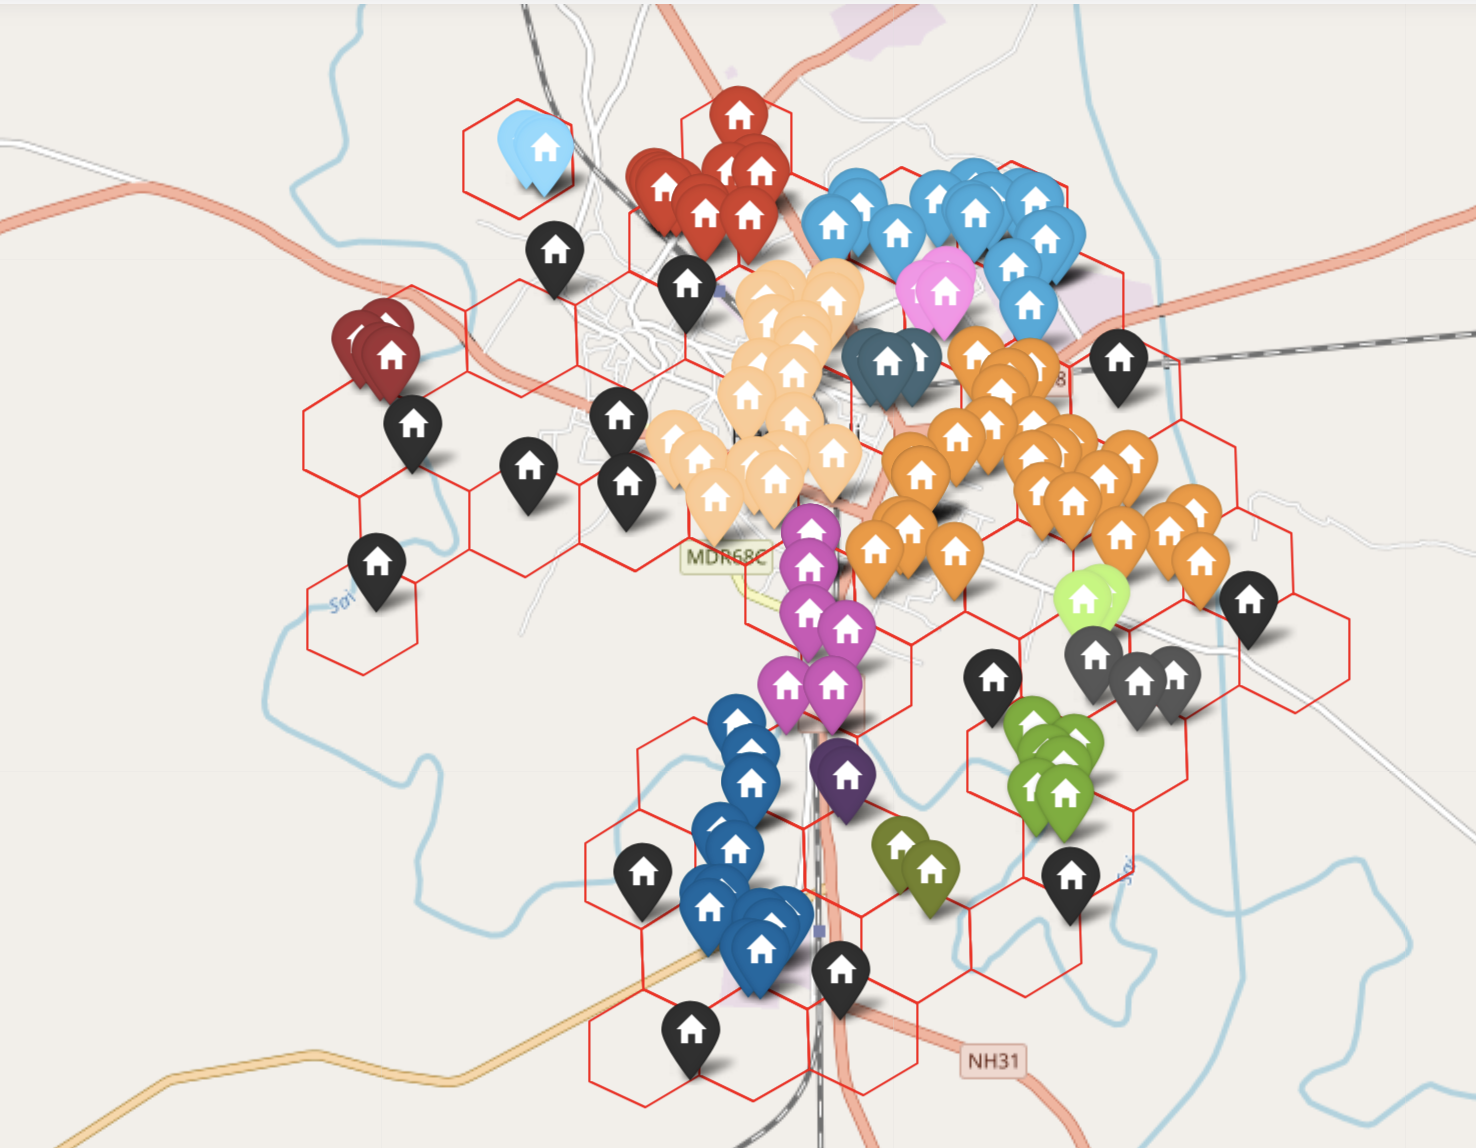

In [11]:
from IPython.display import Image
Image("2.png")

### Now applying k means to each big cluster, two obtain clusters of size nearly 3

In [12]:
dfkm=data.copy()

In [13]:
dbsc_clusters=data.groupby("cluster")["cluster"].size()
dfkm["toreduce"]=dfkm['cluster'].apply(lambda x:dbsc_clusters.loc[x]>5)
dfkm["kval"]=dfkm.apply(lambda row:int((dbsc_clusters.loc[row['cluster']])/3) if (row["toreduce"]==True and row["cluster"]!=-1) else -1,axis=1)
dfkm["cluster"]=dfkm["cluster"].apply(lambda x:str(x)+"-")

In [14]:
reducible_clusters=dfkm.loc[dfkm["kval"]>=2]["cluster"].unique()

In [15]:
from sklearn.cluster import KMeans
for clstr in reducible_clusters:
    kmdf=dfkm[dfkm["cluster"]==clstr]
    #print(kmdf)
    KM=KMeans(n_clusters=kmdf.iloc[0,5], random_state=0)
    kmdf["kmeans_cluster"]=KM.fit_predict(kmdf.loc[:,["lat","long"]].values.tolist())
    kmdf["cluster"]=kmdf.apply(lambda x:x["cluster"]+str(x['kmeans_cluster']),axis=1)
    dfkm.loc[kmdf.index,"cluster"]=kmdf["cluster"]
dfkm.drop(['kval'],axis=1,inplace=True)

In [16]:
clusteredmap2 = folium.Map( location=[data.lat.mean(),data.long.mean()], zoom_start=13)
def color(cluster): 
    colourlist=["red","blue","green", "purple", "orange", "beige", "darkblue", "darkgreen","white", "pink","lightblue","darkred", "lightgreen","gray","cadetblue","darkpurple","lightgray"]
    if cluster=='-1-': 
        col = 'black'
    else:
        dash=cluster.find("-")
        if(dash==len(cluster)-1):
            id=int(cluster[0:dash])
        else:
            id=int(cluster[dash+1:])
        col=colourlist[int(id)%len(colourlist)]
    return col 
      
# Iterating over the LAT,LON,NAME and 
# ELEV columns simultaneously using zip() 
for lat,lan,cluster in zip(dfkm['lat'],dfkm['long'],dfkm['cluster']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.Marker(location=[lat,lan], 
                  icon= folium.Icon(color=color(cluster),icon = 'home')).add_to(clusteredmap2)
h3_address = list(dfkm["hexagon"])
clusteredmap2 = visualize_hexagons(h3_address,folium_map=clusteredmap2)
clusteredmap2

### for github visibility, folium not works

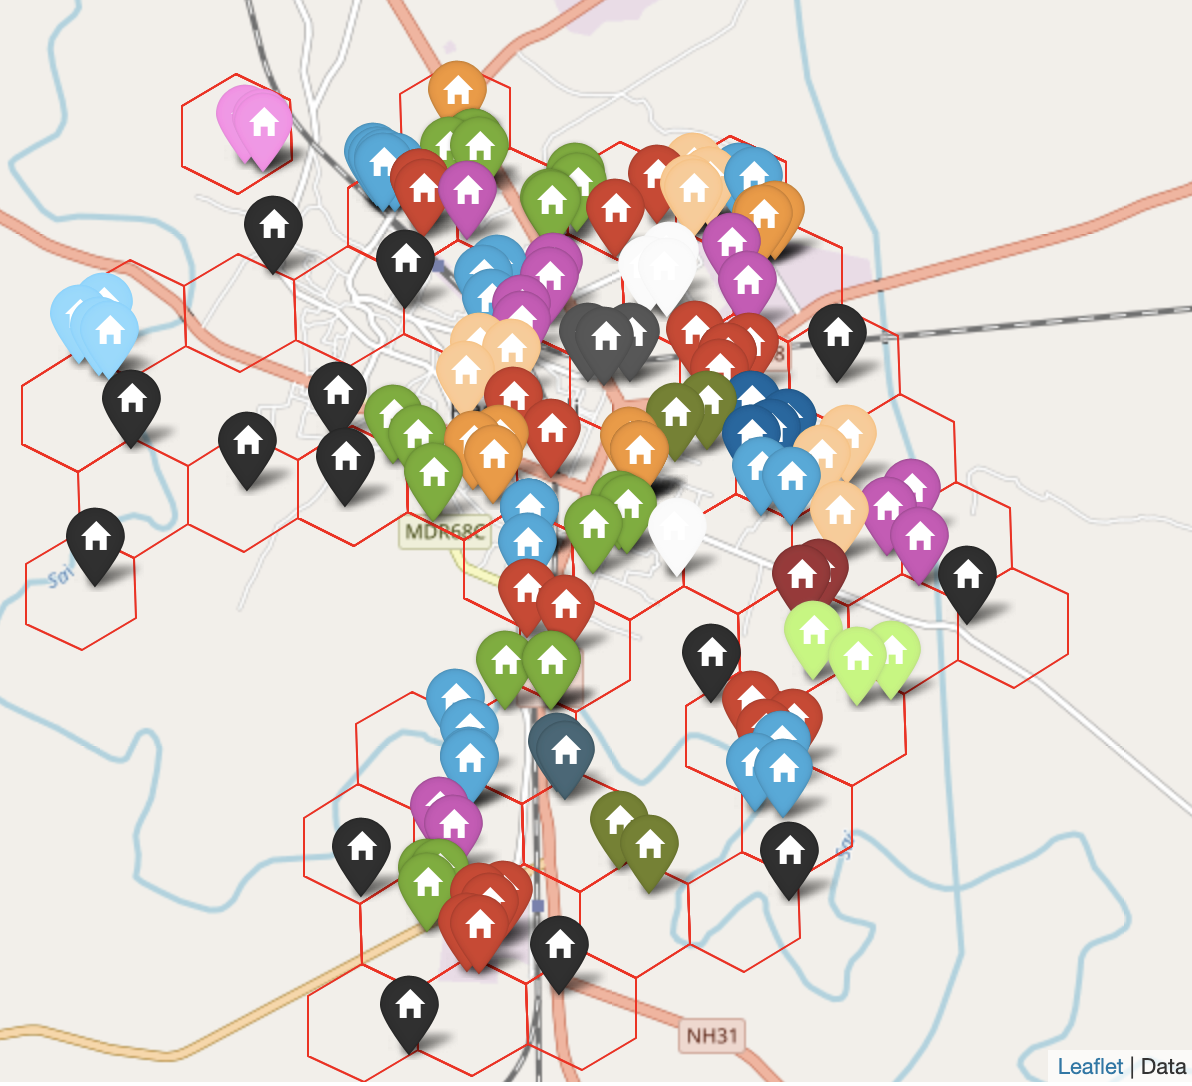

In [17]:
from IPython.display import Image
Image("1.png")